# アメダスと天気予報

データを使う場合に重要なのはデータに関する基本的な知識です。まず気象庁ウェブサイトの「知識・解説」の中の[地域気象観測システム（アメダス）](https://www.jma.go.jp/jma/kishou/know/amedas/kaisetsu.html)を見てどのような気象要素をどこで観測しているのか確認します。アメダスの観測所一覧はCSVをZIP圧縮した形式でも提供されていますが，JSON形式で取得して地図に描いてみましょう。

## 観測所一覧

ファイルをダウンロードするPythonの標準ライブラリには[`urllib.request`](https://docs.python.org/3/library/urllib.request.html)がありますが，[Requests](https://docs.python-requests.org/en/master/)を使うと便利です。ダウンロードが失敗して[例外](https://docs.python.org/ja/3/tutorial/errors.html)が発生する可能性があります。[`with`](https://docs.python.org/ja/3/reference/compound_stmts.html#the-with-statement)文を使うと，例外が発生せずURLを開けた場合にのみ，ブロック（字下げされた文のまとまり）が実行されます。返り値`as`の後の変数に格納されます。これはURLやファイルを開くときの定型の書き方です。

`requests.get()`から返されるオブジェクト`requests.Response`は`reponse`に格納されます。[オブジェクト](https://docs.python.org/ja/3/tutorial/classes.html)とはデータやデータに対するメソッド（操作）をまとめたものです。

In [1]:
import pandas as pd
import requests

url = "https://www.jma.go.jp/bosai/amedas/const/amedastable.json"
with requests.get(url) as response:
    json = response.json()
    df = pd.DataFrame(json).transpose()

In [2]:
df

type     elems         lat          lon alt kjName      knName  \
11001    C  11112010  [45, 31.2]  [141, 56.1]  26    宗谷岬      ソウヤミサキ   
11016    A  11111111  [45, 24.9]  [141, 40.7]   3     稚内       ワッカナイ   
11046    C  11112000  [45, 18.3]   [141, 2.7]  65     礼文         レブン   
11061    C  11110100  [45, 24.2]  [141, 48.1]   8     声問   コエトイ：稚内空港   
11076    C  11112100  [45, 20.1]  [142, 10.2]  13   浜鬼志別     ハマオニシベツ   
...    ...       ...         ...          ...  ..    ...         ...   
94062    B  11111011  [24, 25.6]  [123, 45.9]  10    西表島     イリオモテジマ   
94081    A  11111011  [24, 20.2]   [124, 9.8]   6    石垣島      イシガキジマ   
94086    C  11110000  [24, 23.7]  [124, 14.7]  31     盛山  モリヤマ：新石垣空港   
94101    C  11112000  [24, 15.9]  [123, 52.3]  33     大原        オオハラ   
94116    C  11112000   [24, 3.3]  [123, 46.0]  38    波照間        ハテルマ   

                    enName  
11001            Cape Soya  
11016             Wakkanai  
11046                Rebun  
11061               Koetoi  
11076     Hamaoni-Shibetsu  
...                    ...  
94062  Iriomotejima Island  
94081  Ishigakijima Island  
94086             Moriyama  
94101                Ohara  
94116             Hateruma  

[1295 rows x 8 columns]

サーバから`json()`メソッドを使うとPythonの辞書に変換されます。メソッドは`response.json()`（オブジェクトとメソッドの間にピリオド）のように呼び出します。

リストはデータを`[]`で囲みましたが，辞書は`{}`で囲みます。要素は`key:value`のようにコロンの前に値を探す手がかりとなるキーを書きます。どんなキーがあるかは`keys()`メソッドで調べることができます。`json.keys()`でキーを調べると，印字された最初のキーは`"11001"`です。`json["11001"]`の値は辞書です。つまり，辞書の中に辞書が入れ子になっています。

In [3]:
json["11001"]

{'type': 'C',
 'elems': '11112010',
 'lat': [45, 31.2],
 'lon': [141, 56.1],
 'alt': 26,
 'kjName': '宗谷岬',
 'knName': 'ソウヤミサキ',
 'enName': 'Cape Soya'}

辞書から[pandas](https://pandas.pydata.org/)の`DataFrame`に変換し，`transpose()`メソッドで行と列とを入れ替えます。`DataFrame`はpanasの中心となるデータ構造で表形式のデータの列や行にラベルをつけたものです。

`type`は観測点の種類で，`A`は管区気象台・地方気象台・沖縄気象台，`B`は測候所・特別地域気象観測所（元測候所），`C`は通常のアメダス，`D`, `E`, `F`はそれぞれ父島気象観測所，南鳥島気象観測所，富士山特別気象観測所を表すものと思われます。`elems`は観測要素で，順に気温，降水量，風向，風速，日照時間，積雪深，湿度，気圧の有（`1`）無（`0`）に対応しているようです。日照時間の`2`は観測ではなく推計気象分布に基づく推定値で，2021年3月2日から気象官署・特別地域気象観測所を除く地域気象観測所において提供されています。`elems`の文字列だと気象要素の有無でフィルタしにくいので，1文字ずつ別の列に分解しましょう。

In [4]:
colnames = ["temperature", "precipitation", "windDirection",
"wind", "sunshine", "snowDepth", "humidity", "pressure"]
elems_split = np.array(df["elems"].apply(list).to_list()).astype("int32")
for i in range(len(colnames)):
    df[colnames[i]] = elems_split[:, i]

緯度latと経度lonは度と分のリストになっていますので，十進法に直します。DataFrameでは辞書のように列を選択できます。

In [5]:
df["lat"] = df["lat"].str[0] + df["lat"].str[1]/60
df["lon"] = df["lon"].str[0] + df["lon"].str[1]/60

### 散布図

アメダスの位置を散布図で描いてみましょう。pandasには，matplotlibを使ってデータを可視化する機能があります。

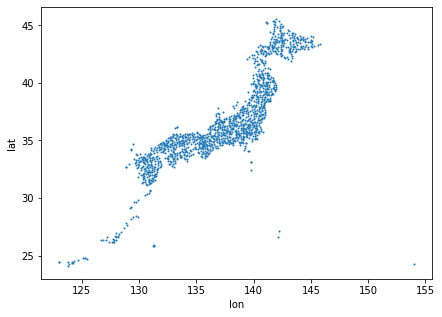

In [7]:
df.plot.scatter(x="lon", y="lat", s=1, figsize=[7,5])
plt.show()

`x`と`y`に軸の値として用いる列を指定します。`s`と`figsize`はそれぞれ点や図のサイズを調整しているだけで，必須ではありません。

アメダスは，日本全国津々浦々に展開されていることがよく分かります。

### 最果てのアメダス

DataFrameの扱い方を練習するために最果てのアメダスを探してみます。`max()`や`min()`メソッドを使うと最大最小が求められます。列は`df.lon`のように選ぶこともできます。`loc`はラベルに基づいた行の選択を行いますが，真偽値を用いることもできます。経度が最大，つまり最東端のアメダスを表示するには次のようにします。

In [8]:
df.loc[df.lon==df.lon.max(), ["kjName", "lon", "lat"]]

kjName         lon        lat
44356    南鳥島  153.983333  24.288333

ここでは，列を観測所の名前，経度，緯度に絞っています。

### 練習

最も東，西，南，北のアメダスを探して地図に表示してください。

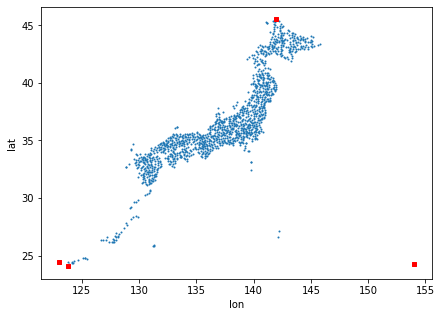

In [11]:
ax = df.plot.scatter(x="lon", y="lat", s=1, figsize=[7,5])
df.loc[(df.lon==df.lon.min()) | (df.lon==df.lon.max()) |
       (df.lat==df.lat.min()) | (df.lat==df.lat.max())].plot.scatter(
        x="lon", y="lat", s=20, c="red", marker="s", ax=ax)
plt.show()

重ねて絵を描くには，最初の図の返り値（`Axes`オブジェクト）を変数`ax`に格納し，次のプロットで`ax`を指定します。

## アメダスデータ

最新のアメダス観測データを使って，pandasに慣れていきましょう。

### 最新の観測時刻の取得

まず，最新の観測時刻を取得します。

In [12]:
url = "https://www.jma.go.jp/bosai/amedas/data/latest_time.txt"
requests.get(url).text

'2021-08-18T16:30:00+09:00'

のようにISO形式YYYY-mm-ddTHH:MM+09:00になっています。最新データ観測時刻を取得して，データのあるURLに使うYYYYmmddHHMMという形式に変換する関数を作ります。ISO形式に基づいて日付と時刻としてパース（解釈）し`datetime`形式に変換した後，`strftime()`メソッドで整形出力しています。

In [13]:
import requests
from datetime import datetime


def get_latest():
    url = "https://www.jma.go.jp/bosai/amedas/data/latest_time.txt"
    with requests.get(url) as response:
        return datetime.fromisoformat(response.text).strftime("%Y%m%d%H%M")

### 最新の観測データの取得

データを取得してDataFrameに格納します。

In [14]:
latest = get_latest()
url = "https://www.jma.go.jp/bosai/amedas/data/map/" + latest + "00.json"

with requests.get(url) as response:
    json = response.json()
df_amedas = pd.DataFrame(json).transpose()

### 前処理

データ列は値と品質フラグのリストになっているので，値を表す最初の要素を残します。また`dropna()`メソッドでNaNを取り除きます。

In [15]:
for col in df_amedas.columns:
    df_amedas[col] = df_amedas[col].dropna().str[0].dropna()

観測点の経度と緯度を観測所一覧から追加します。


In [16]:
df_amedas["lon"] = df.loc[df_amedas.index, "lon"]
df_amedas["lat"] = df.loc[df_amedas.index, "lat"]

### データの可視化

`describe()`メソッドを使うと，統計量（データ数，平均，標準偏差，最小，四分位数，最大）を表示します。また，`hist()`メソッドを呼ぶと，ヒストグラムで分布を確認することができます。

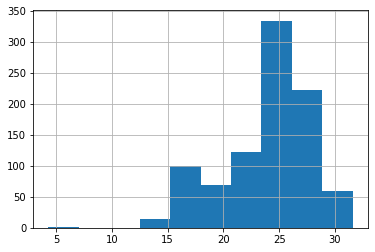

In [17]:
df_amedas["temp"].hist()
plt.show()

気温の空間分布を表示するには，`plot.scatter()`メソッドを用います。`c`に`"temp"`を渡して`cmap`に好みのカラーマップを指定します。

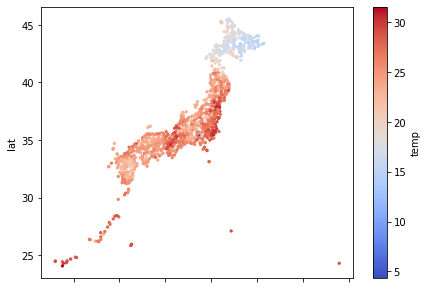

In [18]:
df_amedas.plot.scatter(x="lon", y="lat", c="temp",
    s=5, cmap="coolwarm", figsize=[7,5])
plt.show()

## 週間天気予報

この小節では，JSON形式で府県週間天気予報を取得してpandasの`DataFrame`にまとめてみましょう。まず，予報区の一覧をJSON形式で取得して辞書を作ります。

In [1]:
import requests


url = "http://www.jma.go.jp/bosai/common/const/area.json"
with requests.get(url) as response:
    area = response.json()

ここでは都府県（北海道は支庁，鹿児島県奄美地方と沖縄県は地方）を`area`の中から探します。キーから値ではなく，値からキーを探します。リスト内包表記を使うと短く書けます。

`items()`メソッドでキー`k`と値`v`を一つずつ取り出します。`if`の条件に合う`k`をリストの要素とします。リストではなく単一の要素が必要なので，`[0]`をつけて最初の要素を取り出しています。このキーを使ってJSON形式の予報を取得し辞書に格納します。

In [2]:
pref_code = [k for k, v in area["offices"].items() if v["name"] == "千葉県"][0]
url = f"https://www.jma.go.jp/bosai/forecast/data/forecast/{pref_code}.json"
with requests.get(url) as response:
    forecast = response.json()

予報に含まれる天気予報文はコードとして入っています。コードに対応する予報文は[天気予報](https://www.jma.go.jp/bosai/forecast/)のページのJavaScriptの中にあります。JavaScriptの該当部分からコードと予報文を対応させる辞書を作りました。

In [3]:
import json


TELOPS = {100:["100.svg","500.svg","100","晴","CLEAR"],101:["101.svg","501.svg","100","晴時々曇","PARTLY CLOUDY"],102:["102.svg","502.svg","300","晴一時雨","CLEAR, OCCASIONAL SCATTERED SHOWERS"],103:["102.svg","502.svg","300","晴時々雨","CLEAR, FREQUENT SCATTERED SHOWERS"],104:["104.svg","504.svg","400","晴一時雪","CLEAR, SNOW FLURRIES"],105:["104.svg","504.svg","400","晴時々雪","CLEAR, FREQUENT SNOW FLURRIES"],106:["102.svg","502.svg","300","晴一時雨か雪","CLEAR, OCCASIONAL SCATTERED SHOWERS OR SNOW FLURRIES"],107:["102.svg","502.svg","300","晴時々雨か雪","CLEAR, FREQUENT SCATTERED SHOWERS OR SNOW FLURRIES"],108:["102.svg","502.svg","300","晴一時雨か雷雨","CLEAR, OCCASIONAL SCATTERED SHOWERS AND/OR THUNDER"],110:["110.svg","510.svg","100","晴後時々曇","CLEAR, PARTLY CLOUDY LATER"],111:["110.svg","510.svg","100","晴後曇","CLEAR, CLOUDY LATER"],112:["112.svg","512.svg","300","晴後一時雨","CLEAR, OCCASIONAL SCATTERED SHOWERS LATER"],113:["112.svg","512.svg","300","晴後時々雨","CLEAR, FREQUENT SCATTERED SHOWERS LATER"],114:["112.svg","512.svg","300","晴後雨","CLEAR,RAIN LATER"],115:["115.svg","515.svg","400","晴後一時雪","CLEAR, OCCASIONAL SNOW FLURRIES LATER"],116:["115.svg","515.svg","400","晴後時々雪","CLEAR, FREQUENT SNOW FLURRIES LATER"],117:["115.svg","515.svg","400","晴後雪","CLEAR,SNOW LATER"],118:["112.svg","512.svg","300","晴後雨か雪","CLEAR, RAIN OR SNOW LATER"],119:["112.svg","512.svg","300","晴後雨か雷雨","CLEAR, RAIN AND/OR THUNDER LATER"],120:["102.svg","502.svg","300","晴朝夕一時雨","OCCASIONAL SCATTERED SHOWERS IN THE MORNING AND EVENING, CLEAR DURING THE DAY"],121:["102.svg","502.svg","300","晴朝の内一時雨","OCCASIONAL SCATTERED SHOWERS IN THE MORNING, CLEAR DURING THE DAY"],122:["112.svg","512.svg","300","晴夕方一時雨","CLEAR, OCCASIONAL SCATTERED SHOWERS IN THE EVENING"],123:["100.svg","500.svg","100","晴山沿い雷雨","CLEAR IN THE PLAINS, RAIN AND THUNDER NEAR MOUTAINOUS AREAS"],124:["100.svg","500.svg","100","晴山沿い雪","CLEAR IN THE PLAINS, SNOW NEAR MOUTAINOUS AREAS"],125:["112.svg","512.svg","300","晴午後は雷雨","CLEAR, RAIN AND THUNDER IN THE AFTERNOON"],126:["112.svg","512.svg","300","晴昼頃から雨","CLEAR, RAIN IN THE AFTERNOON"],127:["112.svg","512.svg","300","晴夕方から雨","CLEAR, RAIN IN THE EVENING"],128:["112.svg","512.svg","300","晴夜は雨","CLEAR, RAIN IN THE NIGHT"],130:["100.svg","500.svg","100","朝の内霧後晴","FOG IN THE MORNING, CLEAR LATER"],131:["100.svg","500.svg","100","晴明け方霧","FOG AROUND DAWN, CLEAR LATER"],132:["101.svg","501.svg","100","晴朝夕曇","CLOUDY IN THE MORNING AND EVENING, CLEAR DURING THE DAY"],140:["102.svg","502.svg","300","晴時々雨で雷を伴う","CLEAR, FREQUENT SCATTERED SHOWERS AND THUNDER"],160:["104.svg","504.svg","400","晴一時雪か雨","CLEAR, SNOW FLURRIES OR OCCASIONAL SCATTERED SHOWERS"],170:["104.svg","504.svg","400","晴時々雪か雨","CLEAR, FREQUENT SNOW FLURRIES OR SCATTERED SHOWERS"],181:["115.svg","515.svg","400","晴後雪か雨","CLEAR, SNOW OR RAIN LATER"],200:["200.svg","200.svg","200","曇","CLOUDY"],201:["201.svg","601.svg","200","曇時々晴","MOSTLY CLOUDY"],202:["202.svg","202.svg","300","曇一時雨","CLOUDY, OCCASIONAL SCATTERED SHOWERS"],203:["202.svg","202.svg","300","曇時々雨","CLOUDY, FREQUENT SCATTERED SHOWERS"],204:["204.svg","204.svg","400","曇一時雪","CLOUDY, OCCASIONAL SNOW FLURRIES"],205:["204.svg","204.svg","400","曇時々雪","CLOUDY FREQUENT SNOW FLURRIES"],206:["202.svg","202.svg","300","曇一時雨か雪","CLOUDY, OCCASIONAL SCATTERED SHOWERS OR SNOW FLURRIES"],207:["202.svg","202.svg","300","曇時々雨か雪","CLOUDY, FREQUENT SCCATERED SHOWERS OR SNOW FLURRIES"],208:["202.svg","202.svg","300","曇一時雨か雷雨","CLOUDY, OCCASIONAL SCATTERED SHOWERS AND/OR THUNDER"],209:["200.svg","200.svg","200","霧","FOG"],210:["210.svg","610.svg","200","曇後時々晴","CLOUDY, PARTLY CLOUDY LATER"],211:["210.svg","610.svg","200","曇後晴","CLOUDY, CLEAR LATER"],212:["212.svg","212.svg","300","曇後一時雨","CLOUDY, OCCASIONAL SCATTERED SHOWERS LATER"],213:["212.svg","212.svg","300","曇後時々雨","CLOUDY, FREQUENT SCATTERED SHOWERS LATER"],214:["212.svg","212.svg","300","曇後雨","CLOUDY, RAIN LATER"],215:["215.svg","215.svg","400","曇後一時雪","CLOUDY, SNOW FLURRIES LATER"],216:["215.svg","215.svg","400","曇後時々雪","CLOUDY, FREQUENT SNOW FLURRIES LATER"],217:["215.svg","215.svg","400","曇後雪","CLOUDY, SNOW LATER"],218:["212.svg","212.svg","300","曇後雨か雪","CLOUDY, RAIN OR SNOW LATER"],219:["212.svg","212.svg","300","曇後雨か雷雨","CLOUDY, RAIN AND/OR THUNDER LATER"],220:["202.svg","202.svg","300","曇朝夕一時雨","OCCASIONAL SCCATERED SHOWERS IN THE MORNING AND EVENING, CLOUDY DURING THE DAY"],221:["202.svg","202.svg","300","曇朝の内一時雨","CLOUDY OCCASIONAL SCCATERED SHOWERS IN THE MORNING"],222:["212.svg","212.svg","300","曇夕方一時雨","CLOUDY, OCCASIONAL SCCATERED SHOWERS IN THE EVENING"],223:["201.svg","601.svg","200","曇日中時々晴","CLOUDY IN THE MORNING AND EVENING, PARTLY CLOUDY DURING THE DAY,"],224:["212.svg","212.svg","300","曇昼頃から雨","CLOUDY, RAIN IN THE AFTERNOON"],225:["212.svg","212.svg","300","曇夕方から雨","CLOUDY, RAIN IN THE EVENING"],226:["212.svg","212.svg","300","曇夜は雨","CLOUDY, RAIN IN THE NIGHT"],228:["215.svg","215.svg","400","曇昼頃から雪","CLOUDY, SNOW IN THE AFTERNOON"],229:["215.svg","215.svg","400","曇夕方から雪","CLOUDY, SNOW IN THE EVENING"],230:["215.svg","215.svg","400","曇夜は雪","CLOUDY, SNOW IN THE NIGHT"],231:["200.svg","200.svg","200","曇海上海岸は霧か霧雨","CLOUDY, FOG OR DRIZZLING ON THE SEA AND NEAR SEASHORE"],240:["202.svg","202.svg","300","曇時々雨で雷を伴う","CLOUDY, FREQUENT SCCATERED SHOWERS AND THUNDER"],250:["204.svg","204.svg","400","曇時々雪で雷を伴う","CLOUDY, FREQUENT SNOW AND THUNDER"],260:["204.svg","204.svg","400","曇一時雪か雨","CLOUDY, SNOW FLURRIES OR OCCASIONAL SCATTERED SHOWERS"],270:["204.svg","204.svg","400","曇時々雪か雨","CLOUDY, FREQUENT SNOW FLURRIES OR SCATTERED SHOWERS"],281:["215.svg","215.svg","400","曇後雪か雨","CLOUDY, SNOW OR RAIN LATER"],300:["300.svg","300.svg","300","雨","RAIN"],301:["301.svg","701.svg","300","雨時々晴","RAIN, PARTLY CLOUDY"],302:["302.svg","302.svg","300","雨時々止む","SHOWERS THROUGHOUT THE DAY"],303:["303.svg","303.svg","400","雨時々雪","RAIN,FREQUENT SNOW FLURRIES"],304:["300.svg","300.svg","300","雨か雪","RAINORSNOW"],306:["300.svg","300.svg","300","大雨","HEAVYRAIN"],308:["308.svg","308.svg","300","雨で暴風を伴う","RAINSTORM"],309:["303.svg","303.svg","400","雨一時雪","RAIN,OCCASIONAL SNOW"],311:["311.svg","711.svg","300","雨後晴","RAIN,CLEAR LATER"],313:["313.svg","313.svg","300","雨後曇","RAIN,CLOUDY LATER"],314:["314.svg","314.svg","400","雨後時々雪","RAIN, FREQUENT SNOW FLURRIES LATER"],315:["314.svg","314.svg","400","雨後雪","RAIN,SNOW LATER"],316:["311.svg","711.svg","300","雨か雪後晴","RAIN OR SNOW, CLEAR LATER"],317:["313.svg","313.svg","300","雨か雪後曇","RAIN OR SNOW, CLOUDY LATER"],320:["311.svg","711.svg","300","朝の内雨後晴","RAIN IN THE MORNING, CLEAR LATER"],321:["313.svg","313.svg","300","朝の内雨後曇","RAIN IN THE MORNING, CLOUDY LATER"],322:["303.svg","303.svg","400","雨朝晩一時雪","OCCASIONAL SNOW IN THE MORNING AND EVENING, RAIN DURING THE DAY"],323:["311.svg","711.svg","300","雨昼頃から晴","RAIN, CLEAR IN THE AFTERNOON"],324:["311.svg","711.svg","300","雨夕方から晴","RAIN, CLEAR IN THE EVENING"],325:["311.svg","711.svg","300","雨夜は晴","RAIN, CLEAR IN THE NIGHT"],326:["314.svg","314.svg","400","雨夕方から雪","RAIN, SNOW IN THE EVENING"],327:["314.svg","314.svg","400","雨夜は雪","RAIN,SNOW IN THE NIGHT"],328:["300.svg","300.svg","300","雨一時強く降る","RAIN, EXPECT OCCASIONAL HEAVY RAINFALL"],329:["300.svg","300.svg","300","雨一時みぞれ","RAIN, OCCASIONAL SLEET"],340:["400.svg","400.svg","400","雪か雨","SNOWORRAIN"],350:["300.svg","300.svg","300","雨で雷を伴う","RAIN AND THUNDER"],361:["411.svg","811.svg","400","雪か雨後晴","SNOW OR RAIN, CLEAR LATER"],371:["413.svg","413.svg","400","雪か雨後曇","SNOW OR RAIN, CLOUDY LATER"],400:["400.svg","400.svg","400","雪","SNOW"],401:["401.svg","801.svg","400","雪時々晴","SNOW, FREQUENT CLEAR"],402:["402.svg","402.svg","400","雪時々止む","SNOWTHROUGHOUT THE DAY"],403:["403.svg","403.svg","400","雪時々雨","SNOW,FREQUENT SCCATERED SHOWERS"],405:["400.svg","400.svg","400","大雪","HEAVYSNOW"],406:["406.svg","406.svg","400","風雪強い","SNOWSTORM"],407:["406.svg","406.svg","400","暴風雪","HEAVYSNOWSTORM"],409:["403.svg","403.svg","400","雪一時雨","SNOW, OCCASIONAL SCCATERED SHOWERS"],411:["411.svg","811.svg","400","雪後晴","SNOW,CLEAR LATER"],413:["413.svg","413.svg","400","雪後曇","SNOW,CLOUDY LATER"],414:["414.svg","414.svg","400","雪後雨","SNOW,RAIN LATER"],420:["411.svg","811.svg","400","朝の内雪後晴","SNOW IN THE MORNING, CLEAR LATER"],421:["413.svg","413.svg","400","朝の内雪後曇","SNOW IN THE MORNING, CLOUDY LATER"],422:["414.svg","414.svg","400","雪昼頃から雨","SNOW, RAIN IN THE AFTERNOON"],423:["414.svg","414.svg","400","雪夕方から雨","SNOW, RAIN IN THE EVENING"],425:["400.svg","400.svg","400","雪一時強く降る","SNOW, EXPECT OCCASIONAL HEAVY SNOWFALL"],426:["400.svg","400.svg","400","雪後みぞれ","SNOW, SLEET LATER"],427:["400.svg","400.svg","400","雪一時みぞれ","SNOW, OCCASIONAL SLEET"],450:["400.svg","400.svg","400","雪で雷を伴う","SNOW AND THUNDER"]}

wc_dict = {k:v[3] for k, v in TELOPS.items()}

辞書をファイルに保存しておくと便利です。

In [ ]:
with open("weather_codes.txt", "w") as outfile:
    json.dump(wc_dict, outfile)

保存しておいたファイルを読む場合は，[json](https://docs.python.org/3/library/json.html)ライブラリの`load()`メソッドを使います。

In [21]:
import json


with open("weather_codes.txt", "r") as infile:
    wc_dict = json.load(infile)

それでは予報から府県週間予報を切り出します。府県週間予報は，0から最初で次の1番目にあります。そのうちキー`areas`に信頼度，雨の確率，天気コードが入っています。時刻はISO形式なのでPythonの`datetime`形式に変換して，DataFrameのインデックスとしました。DataFrameを使わずに，取り出したリストを活用することもできます。

In [22]:
from datetime import datetime
import pandas as pd

f1 = forecast[1]["timeSeries"][0]
wf = f1["areas"][0]
reliabilities = wf["reliabilities"]
pops = wf["pops"]
weather_codes = wf["weatherCodes"]
weather = [wc_dict[wc] for wc in weather_codes]
valid = [datetime.fromisoformat(d) for d in f1["timeDefines"]]
pd.DataFrame({"weather":weather, "reliabilities":reliabilities, "pops":pops},
             index=valid)

weather reliabilities pops
2021-08-19 00:00:00+09:00    曇時々晴                   
2021-08-20 00:00:00+09:00    曇時々晴                 30
2021-08-21 00:00:00+09:00    曇時々晴             A   30
2021-08-22 00:00:00+09:00    曇時々晴             C   30
2021-08-23 00:00:00+09:00    曇時々晴             C   30
2021-08-24 00:00:00+09:00    曇時々晴             A   30
2021-08-25 00:00:00+09:00    曇時々晴             A   30